 # 1. Introduction

** Today, we're going to explore Washington House Price Data and will come up with a model to estimate the price of house given all the required features. We'll be doing some basic EDA followed by building multiple regression models from sckit-learn library and will evaluate their performance by comparing the predictions.**


In [1]:
import os
import folium
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from folium.plugins import HeatMap

folds  = 5

sns.set(color_codes=True)

warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import r2_score
from ml_metrics import rmse
from scipy import stats
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

In [2]:
house_price_data = pd.read_csv("/kaggle/input/housesalesprediction/kc_house_data.csv")
house_price_data = house_price_data.drop(["date","id"], axis = 1)

**Not all features are significant for regression task. We'll discard Latitude, Longitude and Zipcode to proceed with the regression models. **

In [3]:
house_price_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 2. Feature Engineering

**Now we'll add some new features to our house price data. When we actually look for a house, we keep all these features mentioned below in our mind:**

* **Age of house** - Age of house extracted by choosing 2020 as a reference year.
* **Is renovated(Categorical)** - 1 for renovated condition, 0 otherwise 
* **Total Area of house** 
* **Basement(Categorical)** - 1 if basement is available, 0 otherwise

In [4]:
# Adding new features
house_price_data["Home_Age"] = 2020 - house_price_data["yr_built"]
house_price_data['is_renovated'] = house_price_data["yr_renovated"].where(house_price_data["yr_renovated"] == 0, 1)
house_price_data['Total_Area'] = house_price_data['sqft_living'] + house_price_data['sqft_lot'] + house_price_data['sqft_above'] + house_price_data['sqft_basement'] 
house_price_data['Basement'] = house_price_data['sqft_basement'].where(house_price_data["sqft_basement"] == 0, 1)

# 3. Visualizing and Examining Data

**This is not a very big data and we do not have too many features. Thus, we have chance to plot most of them and reach some useful analytical results. Drawing charts and examining the data before applying a model is a very good practice because we may detect some possible outliers or decide to do normalization. This is not a must but get know the data is always good. **


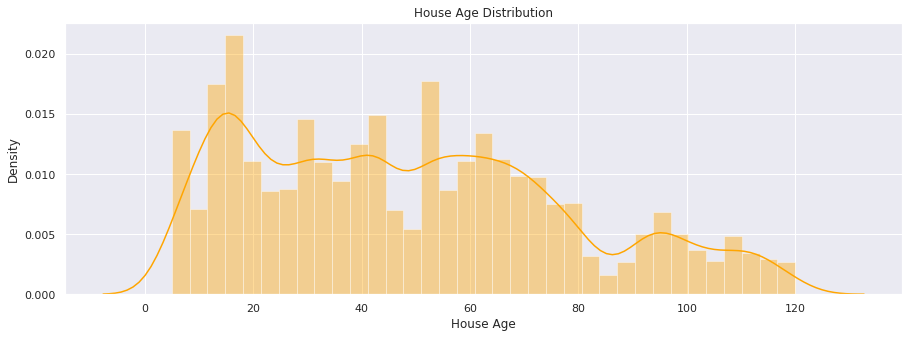

In [5]:
# House Age Distribution 
plt.figure(figsize=(15,5))
sns.distplot(house_price_data["Home_Age"], color="orange")
plt.title("House Age Distribution")
plt.ylabel("Density")
plt.xlabel("House Age");

**Century old houses. Hope these houses are still in living condtion. Although distribution is very skewed.**

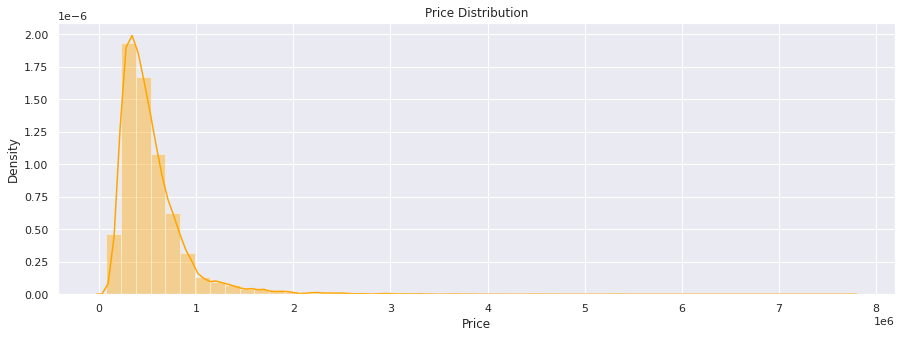

In [6]:
# Price Distribution
plt.figure(figsize=(15,5))
sns.distplot(house_price_data["price"], color="orange")
plt.title("Price Distribution")
plt.ylabel("Density")
plt.xlabel("Price");
sns.set(color_codes=True)

**Prices of house are almost distributed normally with mean roughly centered around 45,000 USD. Also, We're going to ignore the impact of inflation over the years as  it is not mentioned in the data. But introducting inflation can be used to forecast the increment in prices of house for every subsequent year.**

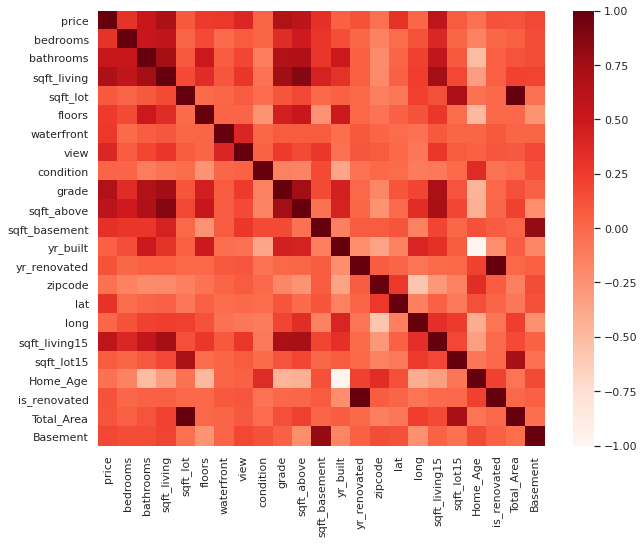

In [7]:
# Exploring correlation between features
plt.figure(figsize=(10,8))
cor = house_price_data.corr()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

** Significant evidence of high correlation between Price and Area of house**

**Distribution of all the parameters with respect to price. Features such as living area, lot area, grade and number bathroom are showing a linear trend with respect to price. Also the distribution below can be used to remove the possible outliers. For this analysis, we're not going to extract outliers but these plots are highly useful for removing outliers form the data**

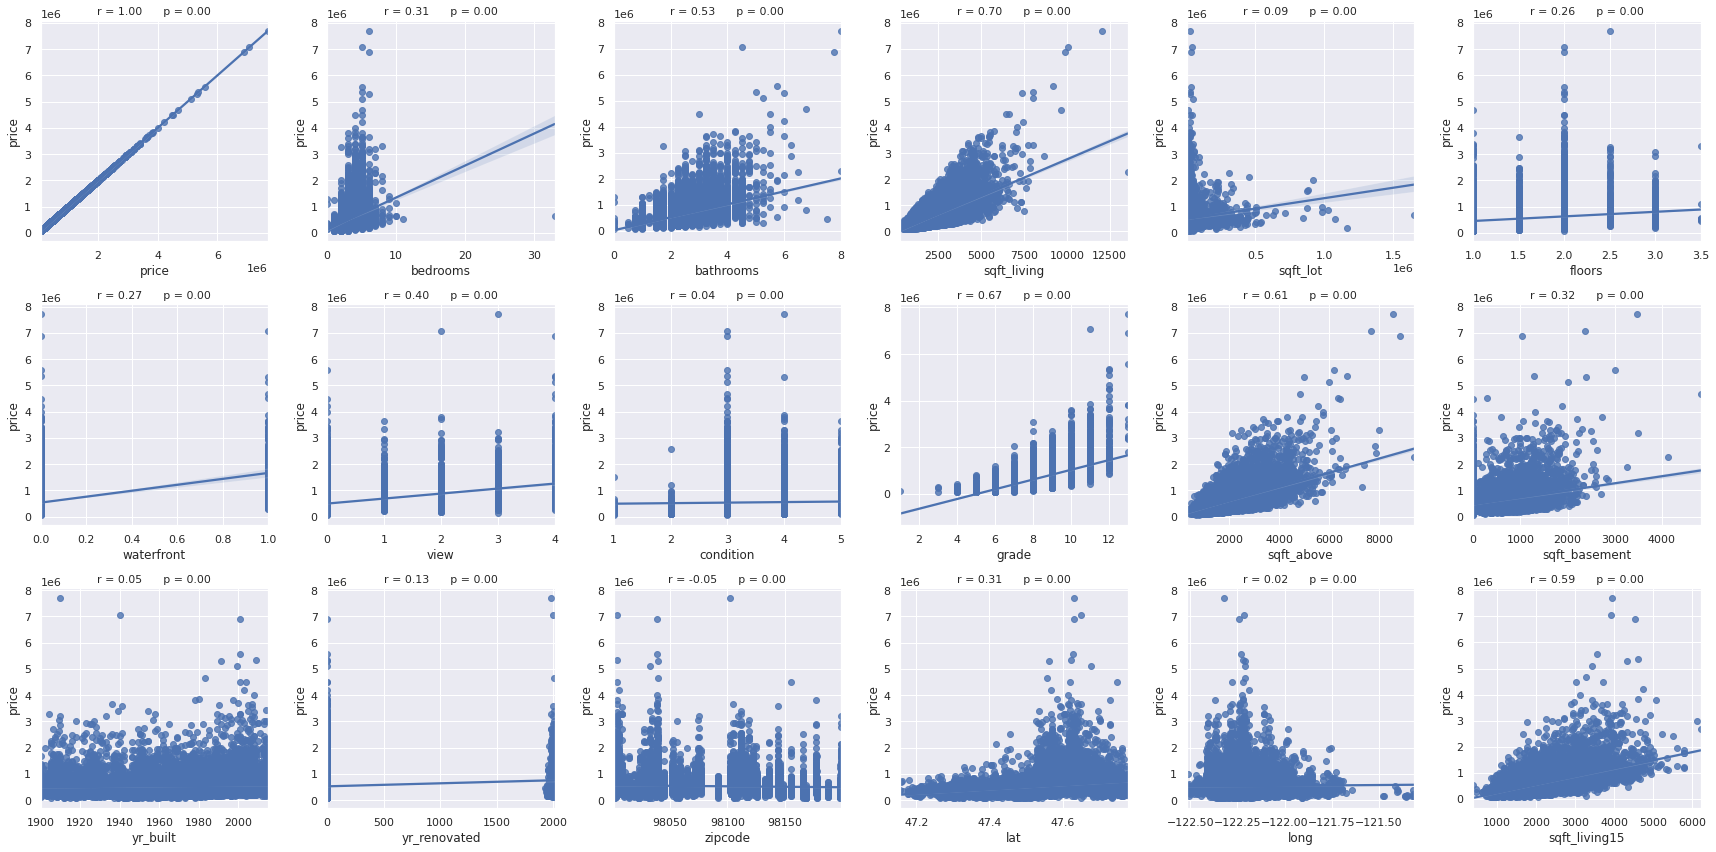

In [8]:
# Distribution of all parameters wrt price.
nr_rows = 3
nr_cols = 6

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*4))

numerical_feats = house_price_data.dtypes[house_price_data.dtypes != "object"].index

li_num_feats = list(numerical_feats)
li_not_plot = ['id']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(house_price_data[li_plot_num_feats[i]], house_price_data['price'], ax = axs[r][c])
            stp = stats.pearsonr(house_price_data[li_plot_num_feats[i]], house_price_data['price'])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
sns.set(color_codes=True)
plt.show()   

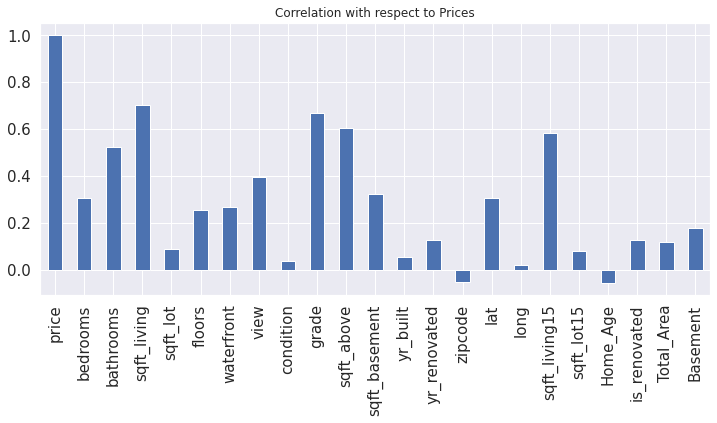

In [9]:
# Features having coorelation to price
sns.set(color_codes=True)
house_price_data.corrwith(house_price_data.price).plot.bar( figsize = (12, 5), title = "Correlation with respect to Prices", fontsize = 15, rot = 90, grid = True);

**Let's make use of Lattitide, Longitude and Zipcode to explore the surrounded area. Thanks to Burhan for this neat heatmap!!**

In [10]:
# Visualizing the surrounding 
maxpr=house_price_data.loc[house_price_data['price'].idxmax()]

def generateBaseMap(default_location=[47.5112, -122.257], default_zoom_start=9.4):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

house_price_data_copy = house_price_data.copy()
house_price_data_copy['count'] = 1
basemap = generateBaseMap()
folium.TileLayer('cartodbpositron').add_to(basemap)
s=folium.FeatureGroup(name='icon').add_to(basemap)
folium.Marker([maxpr['lat'], maxpr['long']],popup='Highest Price: $'+str(format(maxpr['price'],'.0f')),
              icon=folium.Icon(color='green')).add_to(s)
# add heatmap
HeatMap(data=house_price_data_copy[['lat','long','count']].groupby(['lat','long']).sum().reset_index().values.tolist(),
        radius=8,max_zoom=13,name='Heat Map').add_to(basemap)
folium.LayerControl(collapsed=False).add_to(basemap)
basemap

In [11]:
# Correlation wrt price
corr = house_price_data.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, 'price')['price']
print(ser_corr)

price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
floors           0.256794
Basement         0.180230
yr_renovated     0.126434
is_renovated     0.126092
Total_Area       0.119763
sqft_lot         0.089661
sqft_lot15       0.082447
Home_Age         0.054012
yr_built         0.054012
zipcode          0.053203
condition        0.036362
long             0.021626
Name: price, dtype: float64


# **Conclusion from EDA:**

**We see that for some features like 'sqft_living' and 'grade' there is a strong linear correlation of (0.70) and (0.67) to the target.
For this kernel I decided to use all features for prediction that have correlation with SalePrice.
In future work, we can try to drop some columns that have weak correlation with the target price. 
Also, we can remove the outliers from the data for better model building practices. **

**Creating Data Split for training and testing purpose. Also, using a scaled version of dataset for certain algorithms.**

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

target = house_price_data["price"]
features = house_price_data.drop("price", axis = 1)

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = 0.3, random_state = 1)

sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train))
X_test_sc = pd.DataFrame(sc.transform(X_test))

**Using Grid Search Cross Validation for choosing the best parameters of models based on obtained scores.**

In [13]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

# 4. Model Building

**Scikit-learn offers a wide variety of regression algorithms. We'll build simple to complex regression models using different algorithms and will compare the results obtained over different models with our testing dataset which contains 30% of original dataset. For tuning the model and selecting optimum parameters. We'll use GridSearch cross validation.**

**We test the following Regressors from scikit-learn:**
* LinearRegression
* Ridge
* Lasso
* Stochastic Gradient Descent
* DecisionTreeRegressor
* RandomForestRegressor
* KNN Regressor
* XGBoost Regressor

# **Linear Regression**

In [14]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv = folds, verbose = 1 , scoring = score_calc)
grid_linear.fit(X_train, Y_train)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


193195.15010978607
{'copy_X': True, 'fit_intercept': False, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.4s finished


In [15]:
LR = LinearRegression()
LR.fit(X_train, Y_train)
pred_linreg_all = LR.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [16]:
# Rsquared Score for Linear Regression
r2_score(Y_test, pred_linreg_all)

0.6906858360346787

# Stochastic Gradient Descent Regressor

In [17]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv = folds, verbose = 0, scoring = score_calc)
grid_sgd.fit(X_train_sc, Y_train)

sc_sgd = get_best_score(grid_sgd)
pred_sgd = grid_sgd.predict(X_test_sc)

195152.6367324374
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, average=False, early_stopping=False, epsilon=0.01,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=10000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)


In [18]:
# Rsquared Score for SGD Regressor
r2_score(Y_test, pred_sgd)

0.6869465315566647

# Decision Tree Regressor

In [19]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }

grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = folds, refit = True, verbose = 0, scoring = score_calc)
grid_dtree.fit(X_train, Y_train)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

163071.08682708614
{'max_depth': 9, 'max_features': 13, 'max_leaf_nodes': None, 'min_samples_split': 25, 'presort': False, 'random_state': 5}
DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=9,
                      max_features=13, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=25,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=5, splitter='best')


In [20]:
# Rsquared Score for DTree Regression
r2_score(Y_test, pred_dtree)

0.7815542564651639

# RandomForest Regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_rf.fit(X_train, Y_train)

sc_rf = get_best_score(grid_rf)
pred_rf = grid_rf.predict(X_test)

127410.50401389084
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)


In [22]:
# Rsquared Score for RandomForest
r2_score(Y_test, pred_rf)

0.8620529874128451

# KNN Regressor

In [23]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,              
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_knn.fit(X_train_sc, Y_train)
sc_knn = get_best_score(grid_knn)
pred_knn = grid_knn.predict(X_test_sc)

164075.46044278468
{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='distance')


In [24]:
# Rsquared Score for KNN
r2_score(Y_test, pred_knn)

0.7757958918344088

# XGBoost Regressor

In [25]:
from xgboost import XGBRegressor
param_grid = {'learning_rate' : [0.005,0.01,0.001], 'n_estimators' : [40,200], 'random_state': [5],
              'max_depth' : [4,9]}
grid_xgb = GridSearchCV(XGBRegressor(), param_grid, cv = folds, refit=True, verbose = 0, scoring = score_calc)
grid_xgb.fit(X_train, Y_train)

sc_xgb = get_best_score(grid_xgb)
pred_xgb = grid_xgb.predict(X_test)

159135.8217031751
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 200, 'random_state': 5}
XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=5, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)


In [26]:
# Rsquared Score for XGBoost Regressor
r2_score(Y_test, pred_xgb)

0.7688578023610281

# Result Evaluation

**Linear Regression models gave up high RMSE. Also, XGB, KNN and Dtree models performed similarly with roughly 162.5k RMS error in estimation. While RandomForest recorded the lowest RMS error.**

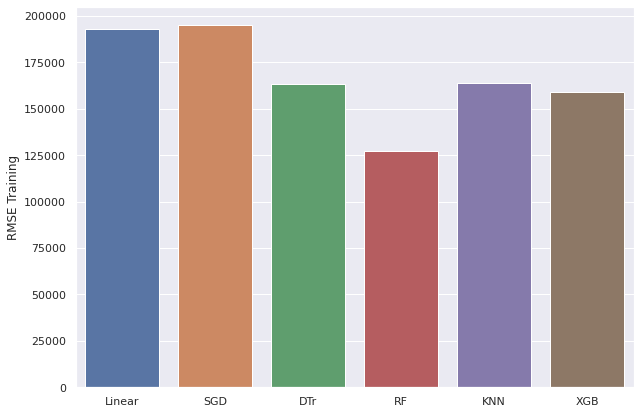

In [27]:
list_scores = [sc_linear,sc_sgd, sc_dtree, sc_rf, sc_knn, sc_xgb]
list_predictions = [pred_linreg_all, pred_sgd, pred_dtree, pred_rf, pred_knn, pred_xgb]
list_regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE Training')
plt.show()

# Moment of truth
**Let's compare the overall RMS error secured by models over the testing dataset.**
**RandomForest outformed all the models in the analysis and secured a rms value less than 150K which means we can actually use the RandomForest model in estimating the house price given all the other features.**

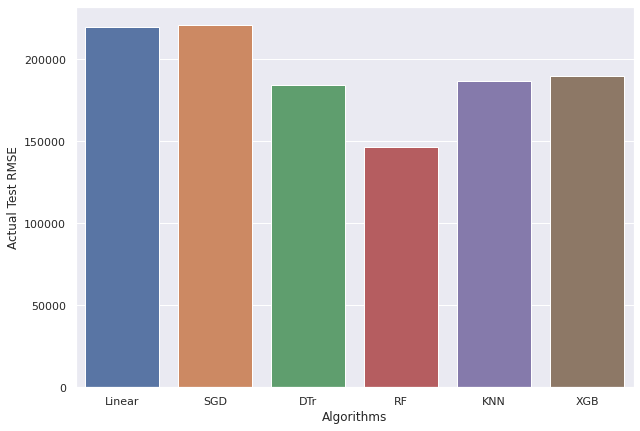

In [28]:
errors = []
for pred in list_predictions:
    errors.append(rmse(Y_test, pred))
    
regressors = ['Linear','SGD','DTr','RF','KNN','XGB']
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x = regressors, y = errors, ax=ax)
plt.ylabel('Actual Test RMSE')
plt.xlabel('Algorithms')
plt.show()

In [29]:
predictions = {'Linear': pred_linreg_all,
               'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn, 'XGB': pred_xgb}
df_predictions = pd.DataFrame(data=predictions) 

# How closely the predictions are related from different models

**Only for Random Forest, Decision Tree and XGBoost, the results are less correlated with the other Regressors.**

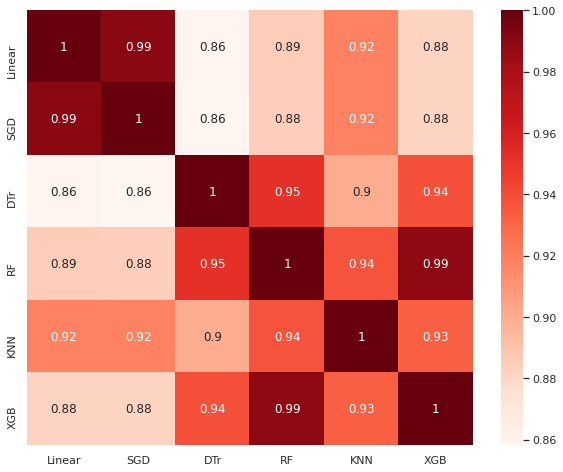

In [30]:
plt.figure(figsize=(10,8))
cor_pred = df_predictions.corr()
sns.heatmap(cor_pred, annot=True, cmap=plt.cm.Reds)
plt.show()

# 5. Conclusion

So far, we explored the data and added some new features into it. We did some EDA to visualize the impact of features over the traget price variable. Then we built multiple regression models and evaluated their preformance over the test dataset. RandomForest outformed other models and gave a RMSE slightly lower than 150k. We also compared correlation from different predicted estimates over the testing dataset. That's all folks!!

**Future Work**: I think by tuning the parameters of XGBoost, we can achieve lower RMSE than RandomForest. I'll update the kernel later by improving the RMSE from XGBoost Regressor.

If you like this kernel than I would appreciate an **upvote** from you. 

Thanks!!
